#  <font color=#8A0808><center><span style="border:1px solid black;"> Projet Python </center></font>
<b> Vincent LE MEUR, Margaux GOUYSSE </b>
###  <font color=#045FB4><center><b>Tentative de prédiction de la schizophrénie à partir d'ElectroEncéphaloGramme</b></center></font>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Importation des librairies

In [2]:
import numpy 
import pandas 
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, log_loss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import scipy
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
from sklearn.tree import DecisionTreeClassifier 
from sklearn.grid_search import GridSearchCV

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Références et Vocabulaire

Notre étude est tirée de l'article suivant : 
https://www.ncbi.nlm.nih.gov/pubmed/23754836

Les données propre à l'étude sont issues de : 
https://www.kaggle.com/broach/button-tone-sz

Enfin le vocabulaire utilisé dans ce notebook : 

- ERP pour Event-Related Potential ou potentiel évoqué en français, désigne le signal électrique cérébral mesuré par électroencéphalographie en réponse à une stimulation sensorielle, un processus cognitif ou tout autre activité mentale.
- EEG désigne un ElectroEncéphaloGramme
- Trial : essai clinique

## Contexte général de l'étude

L'objectif de ce notebook est de présenter une approche tentant de prédire la schizophrénie à partir de relevés d' EEG issus de patients schizophrènes et non schizophrènes (patients de contrôle).

En effet, les humains (comme beaucoup d'autres espèces) ont la capacité de réduire ou de réprimer les réactions de leur cerveau à la suite d'un stimuli sensoriel issu de leurs propres actions.
Le système nerveux accomplit ceci avec un système de décharge corollaire dans lequel une «copie d'efference» d'un plan moteur imminent est transmise au cortex sensoriel où il produit une représentation de «décharge corollaire». Par exemple, lorsque nous déplaçons nos yeux de gauche à droite, notre cerveau sait que l'environnement ne change pas. Quand nous parlons, notre cortex auditif a une réponse réduite au son attendu de notre voix : tout cela est alors due à cette décharge.

Nous allons alors étudié l'expérience EEG suivante  :

Des sujets avaient pour objectif d'effectuer trois actions donnant trois conditions expérimentales : <b>
- Condition (1) appuyer sur un bouton générant un son et l'écouter
- Condition (2) écouter passivement le même son 
- Condition (3) appuyer sur un bouton sans générer de son</b>

Afin de mesurer les ondes cérébrales, on place alors sur les patients un casque composé d'électrodes réparties selon le schéma ci-dessous : 

![title](cap64r.png)

<u>Résultats cliniques : </u>

<b>Les patients non schizophrènes, appelés patients de contrôle, suppriment une déflexion négative de l'onde cérébrale de l'EEG (appellée N100) 100 millisecondes après le début d'un son lorsque ils appuyaient sur un bouton. Les patients atteints de schizophrénie auraient tendance à présenter une déflexion moins nette. Une deuxième déflexion d'amplitude nommée P200 intervient juste après le N100 et nous est accessible pour l'étude.</b>

Ces résultats traduisent alors le fait que le cerveau des patients de contrôle arrive à prédire l'évènement qui va se produire de manière plus efficace que les patients schizophrènes, et vont donc prédire une réponse réduite au son qui va être généré par le bouton. Ceci peut alors laisser penser que cette réponse réduite permet de supprimer des bruits "parasites" de l'environnement, moins bien supprimés par les patients schizophrènes.

## Données d'études

Les données brutes dont nous disposons sont celles des potentiels électriques de 9 électrodes (visible dans le schéma précédent encadrées en rouge) : Cz,Fz,FCz,C3,C4,FC3,FC4,CP3 et CP4. 

Pour chacune de ces électrodes nous avons la valeur moyenne en amplitude de la déflexion N100, P200 mais également les valeurs d'amplitude de ces électrodes avant ces événements (ce qui va nous permettre d'effectuer à chaque fois une normalisation). Ces valeurs sont désignées par B0 et B1 respectivement.

Nous disposons alors des données expérimentales de 81 patients (dont la moitié environ constitue le groupe de contrôle). Chaque patient a réalisé chacune des trois expériences cliniques près d'une centaine de fois (donc une centaine de trials par condition et par patient).

Nous avons également à notre disposition quelques données démographiques pour chaque patient : l'age (en années), le sexe (F ou M), l'éducation (en années) et enfin une variable binaire group (valant 0 ou 1) indiquant la schizophrénie ou non des  patients (1 pour la schizophrénie, 0 sinon).

Enfin, nous disposons également d'une colonne 'ITI' qui correspond uniquement au temps entre chaque essai clinique (trial) ainsi que d'une colonne 'rejected' qui prend 0 ou 1 (0 si on a réussi à effectuer toutes les mesures pour un essai, 1 si une des mesures n'a pas pu être faite afin de rejeter l'essai).

In [3]:
data = pandas.read_csv("MergedTrialData.csv",sep=",")
subinfo = pandas.read_csv("demographic.csv",sep=",")

In [4]:
data.head()

,subject,trial,condition,ITI,rejected,Fz_N100,FCz_N100,Cz_N100,FC3_N100,FC4_N100,...,CP4_B0,Fz_B1,FCz_B1,Cz_B1,FC3_B1,FC4_B1,C3_B1,C4_B1,CP3_B1,CP4_B1
0,1,1,1,NaN,0,-9.761338,-11.545219,-16.775214,-3.576595,-11.745167,...,-0.005642,-14.815963,-23.173850,-25.626646,-13.285282,-23.223037,-23.622596,-19.071931,-19.529142,-26.677147
1,1,2,1,2025.3906,0,8.717519,11.462619,7.979110,9.429738,6.912862,...,0.066728,19.337457,18.359870,15.224155,13.442292,16.981404,11.953868,10.168470,5.831319,6.503993
2,1,3,1,2303.7109,0,-4.027286,-3.992038,-1.104119,-3.319471,0.321314,...,0.011351,5.443106,1.081921,0.316871,1.199502,0.929950,1.343815,3.131847,3.691148,0.338882
3,1,4,1,2275.3906,0,0.394095,-0.663186,-1.372871,3.974643,-1.613667,...,0.010070,5.417850,3.702130,7.823421,5.336565,-0.448384,7.983687,6.579145,8.474662,9.381523
4,1,5,1,2464.8438,0,-9.368090,-12.029829,-10.280100,-7.846471,-8.170986,...,-0.082809,-6.464376,-6.817497,-6.286747,0.212776,-5.815893,2.517058,-1.101036,-4.325141,-4.832745


Ces données ont été pré-traitées depuis leur acquisition (filtre passe haut,moyennisation, retrait des "outliers", etc...)

In [5]:
subinfo.columns = ['subject','group','gender','age','education']
subinfo.head()

,subject,group,gender,age,education
0,1,0,M,44,16.0
1,2,0,M,39,17.0
2,3,0,M,53,18.0
3,4,0,M,52,15.0
4,5,0,M,41,16.0


## Etude démographique

Dans cette partie, nous allons réaliser une étude statistique de nos patients en considérant leurs données démographiques.

In [6]:
print(subinfo.loc[subinfo["group"]==0].describe())
print(subinfo.loc[subinfo["group"]==1].describe())

         subject  group        age  education
count  32.000000   32.0  32.000000  32.000000
mean   25.000000    0.0  38.375000  15.921875
std    22.854378    0.0  13.918542   1.959713
min     1.000000    0.0  22.000000  12.000000
25%     8.750000    0.0  24.750000  15.000000
50%    16.500000    0.0  38.500000  16.000000
75%    32.750000    0.0  52.250000  17.000000
max    66.000000    0.0  63.000000  19.000000
         subject  group        age  education
count  49.000000   49.0  49.000000   49.00000
mean   51.448980    1.0  40.020408   13.55102
std    17.408165    0.0  13.483771    1.95588
min    25.000000    1.0  19.000000    9.00000
25%    37.000000    1.0  27.000000   12.00000
50%    49.000000    1.0  41.000000   13.00000
75%    69.000000    1.0  50.000000   16.00000
max    81.000000    1.0  63.000000   16.00000


On peut voir que les deux échantillons ont la même variance pour les variables âge et éducation. On va donc pouvoir effectuer deux tests de Student sur ces variables afin de vérifier l'homogénéité des deux groupes en âge et en terme d'éducation.

In [7]:
subinfo1 = subinfo.loc[subinfo["group"]==1]
subinfo0 = subinfo.loc[subinfo["group"]==0]

In [8]:
scipy.stats.ttest_ind(subinfo1["age"],subinfo0["age"])

Ttest_indResult(statistic=0.53012683519706305, pvalue=0.59751090096035231)

La p-value obtenue par le biais du test de Student nous indique qu'il est impossible de rejeter l'hypothèse <b> H0 : "La différence entre les moyennes des âges des patients de contrôle et des schizophrènes est nulle". </b> On peut donc en conclure que les âges sont distribués de manière analogue entre nos deux groupes. 

On effectue le test de student également pour la variable éducation : 

In [9]:
scipy.stats.ttest_ind(subinfo1["education"],subinfo0["education"])

Ttest_indResult(statistic=-5.3291651101540687, pvalue=9.0857532312120843e-07)

Cette fois, la p-value nous indique que la variable "education" ne semble pas bien répartie entre les deux groupes. La variable "education" étant en années, cela pourrait être dû au fait que la schizophrénie peut influencer le temps d'étude.

Intéressons-nous maintenant à la variable concernant le genre : 

In [10]:
subinfo0["nb"]=1
genre0 = subinfo0[["gender","nb"]].groupby("gender").count()
subinfo1["nb"]=1
genre1 = subinfo1[["gender","nb"]].groupby("gender").count()
print(genre0)
print(genre1)

        nb
gender    
 F       6
 M      26
        nb
gender    
 F       8
 M      41


/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Cette fois, la variable genre est de type dichotomique, on va donc effectuer un test du chi 2 afin de vérifier l'homogénéité des deux échantillons.

In [11]:
genre0 = pandas.DataFrame(genre0.to_records())
genre1 = pandas.DataFrame(genre1.to_records())
genre = genre1.merge(genre0,left_on="gender",right_on="gender")

In [12]:
genre=genre.drop("gender",axis=1)
scipy.stats.chi2_contingency(genre)

(0.00034420417953961823,
 0.98519790396775608,
 1,
 array([[  8.4691358,   5.5308642],
        [ 40.5308642,  26.4691358]]))

La p-value élevée obtenue (0.98) pour la variable "gender" nous indique qu'il est impossible de rejeter l'hypothèse d'équivalence en genre pour les deux groupes d'invidus.

La variable "education" ne nous intéressant pas pour cette étude, nous pouvons conclure grâce à ces tests statistiques que l'échantillon semble exploitable (les deux groupes étant distribués de manière analogue en âge et en genre).

## Pré-traitement des données

Les données précédentes ne sont pas exploitables telles quelles. En suivant, l'avis médical de l'article, il faut d'abord mettre en place une normalisation des données en retranchant à chaque mesure (N100 et P200) la valeur des amplitude de références B0 ou B1 (étape de normalisation) en fonctions des électrodes.

Par ailleurs, il est nécessaire dans un second temps d'exploiter chacune des trois conditions expérimentales.

En effet, le schéma ci-dessous nous montre (figure C) qu'il semble possible de constater une différence pour les patients de contrôle (HC) et les patients schizophrènes (SZ) en observant la moyenne de certaines électrodes (Fz,FCz,Cz) entre deux événements "Play Tone" et "Button Tone".

![title](fig1.png)

Expérimentalement "Play Tone" correspond à la condition 2. En revanche "Button Tone" s'obtient en retranchant à la condition 1, la condition 3 afin d'enlever l'influence de la pression sur le bouton au niveau de nos données.

Le second schéma ci-dessous, nous montre (figure B) qu'un autre axe d'étude serait de comparer les valeurs entre l'hémisphère gauche et l'hémisphère droit du cerveau pour d'autres électrodes (C3,C4,CP3,CP4,FC3,FC4) pour deux conditions expérimentales "Button Tone" (condition créée) et Button Alone (condition 3)

![title](fig2.png)

<b> L'objectif de cette partie est d'avoir à disposition l'ensemble de ces variables </b>

Comme évoqué précedemment, certains essais sont rejetés de l'étude (rejected=1) car la mesure des amplitudes n'a pas pu être effectuée. Cela se solde par un "NaN" dans notre dataset. Nous supprimons alors cette colonne puisque nous pourrons identifier les essais rejetés grâce aux valeurs "NaN". Nous supprimons égalemment la colonne ITI qui correspond aux temps entre deux mesures qui ne nous intéressent pas dans notre étude :

In [13]:
dataset = data.copy()
del dataset["ITI"]
del dataset["rejected"]

Nous effectuons ci-dessous l'étape de normalisation : 

In [14]:
dataset["Fz_N100"] = dataset["Fz_N100"] - dataset["Fz_B0"]
dataset["FCz_N100"] = dataset["FCz_N100"] - dataset["FCz_B0"]
dataset["Cz_N100"] = dataset["Cz_N100"] - dataset["Cz_B0"]
dataset["Fz_P200"] = dataset["Fz_P200"] - dataset["Fz_B0"]
dataset["FCz_P200"] = dataset["FCz_P200"] - dataset["FCz_B0"]
dataset["Cz_P200"] = dataset["Cz_P200"] - dataset["Cz_B0"]
dataset["FC3_N100"] = dataset["FC3_N100"] - dataset["FC3_B1"]
dataset["FC4_N100"] = dataset["FC4_N100"] - dataset["FC4_B1"]
dataset["C3_N100"] = dataset["C3_N100"] - dataset["C3_B1"]
dataset["C4_N100"] = dataset["C4_N100"] - dataset["C4_B1"]
dataset["CP3_N100"] = dataset["CP3_N100"] - dataset["CP3_B1"]
dataset["CP4_N100"] = dataset["CP4_N100"] - dataset["CP4_B1"]
dataset["FC3_P200"] = dataset["FC3_P200"] - dataset["FC3_B1"]
dataset["FC4_P200"] = dataset["FC4_P200"] - dataset["FC4_B1"]
dataset["C3_P200"] = dataset["C3_P200"] - dataset["C3_B1"]
dataset["C4_P200"] = dataset["C4_P200"] - dataset["C4_B1"]
dataset["CP3_P200"] = dataset["CP3_P200"] - dataset["CP3_B1"]
dataset["CP4_P200"] = dataset["CP4_P200"] - dataset["CP4_B1"]
dataset = dataset.drop(['Fz_B0', 'FCz_B0', 'Cz_B0', 'FC3_B0', 'FC4_B0',
       'C3_B0', 'C4_B0', 'CP3_B0', 'CP4_B0', 'Fz_B1', 'FCz_B1', 'Cz_B1',
       'FC3_B1', 'FC4_B1', 'C3_B1', 'C4_B1', 'CP3_B1', 'CP4_B1'],axis=1)

Par ailleurs, on observant par exemple la valeur ci-dessous :

In [15]:
dataset.loc[(dataset["subject"]==1) & (dataset["trial"]==3)]

,subject,trial,condition,Fz_N100,FCz_N100,Cz_N100,FC3_N100,FC4_N100,C3_N100,C4_N100,...,CP4_N100,Fz_P200,FCz_P200,Cz_P200,FC3_P200,FC4_P200,C3_P200,C4_P200,CP3_P200,CP4_P200
2,1,3,1,-4.044253,-4.005437,-1.146849,-4.518973,-0.608635,-0.924276,-3.101228,...,2.392652,11.468599,13.744479,18.326146,11.285627,13.057485,13.315946,10.278402,14.972074,15.771931
102,1,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,1,3,3,1.480576,3.310654,4.764502,6.461793,7.692034,4.244982,5.541014,...,-0.413022,-9.002055,-11.191066,-8.878483,-9.820571,-0.524478,-5.393448,-2.694416,-6.644806,-5.740191


On constate que si une mesure n'a pas pu être effectuée pour un sujet spécifique pour un essai en particulier et pour une condition, cela n'entraine pas le rejet des autres conditions et donc de l'essai tout entier. Nous avons décider de supprimer l'essai tout entier pour un sujet si une des conditions a été rejetée.

Afin de pouvoir supprimer plus facilement l'essai tout entier, on transforme notre set de données :

In [16]:
datamelt=pandas.melt(dataset,id_vars=["subject","trial","condition"])
datamelt["variable"] = datamelt["variable"] + "_" + datamelt["condition"].map(str)
piv = datamelt.pivot_table(columns="variable",values="value",index=["subject","trial"])
piv.head()

variable       C3_N100_1  C3_N100_2  C3_N100_3  C3_P200_1  C3_P200_2  \
subject trial                                                          
1       1      22.727177 -24.911931        NaN  25.190606 -10.979526   
        2      -5.711525 -13.953359  26.960172 -10.385134   5.382648   
        3      -0.924276        NaN   4.244982  13.315946        NaN   
        4      -5.607664 -13.745863  10.755793   6.457337  11.832054   
        5     -12.709287 -12.473828   7.215630   4.440625  10.007401   

variable       C3_P200_3  C4_N100_1  C4_N100_2  C4_N100_3  C4_P200_1  \
subject trial                                                          
1       1            NaN   2.392726 -14.481077        NaN   3.525016   
        2      28.410166  -5.478370  -7.643607  25.202158   0.337484   
        3      -5.393448  -3.101228        NaN   5.541014  10.278402   
        4      15.896154  -8.083645 -10.703733   8.851290   6.447726   
        5       2.958567  -5.806059 -11.292634  10.401057   7.002258   

variable         ...      FCz_N100_3  FCz_P200_1  FCz_P200_2  FCz_P200_3  \
subject trial    ...                                                       
1       1        ...             NaN   -6.716866  -10.378150         NaN   
        2        ...       10.149065    9.870649   18.979517   10.306680   
        3        ...        3.310654   13.744479         NaN  -11.191066   
        4        ...       12.231993   13.590669   21.945555   12.961642   
        5        ...       12.052427    2.341504    8.119649    3.605267   

variable       Fz_N100_1  Fz_N100_2  Fz_N100_3  Fz_P200_1  Fz_P200_2  \
subject trial                                                          
1       1      -9.807368 -16.661582        NaN  -4.327396  -9.721672   
        2       8.652131  -3.743841   7.888594   6.542024  11.456085   
        3      -4.044253        NaN   1.480576  11.468599        NaN   
        4       0.362497  -8.250214   8.512272  11.740797  18.244960   
        5      -9.308139  -8.185970   6.319087   3.889608   1.767872   

variable       Fz_P200_3  
subject trial             
1       1            NaN  
        2       8.611427  
        3      -9.002055  
        4       7.231305  
        5      -0.122603  

[5 rows x 54 columns]

In [17]:
#on supprime les NaN
piv = piv.dropna(how='any')
#on retransforme en dataframe
df = pandas.DataFrame(piv.to_records())
#on fusionne avec la table des données démographiques
df = subinfo.merge(df,left_on="subject",right_on="subject")

In [18]:
#####table avec condition = 1-3 - 2####
df2=df[["subject","group","C3_N100_2","C3_N100_3","C3_P200_2","C3_P200_3","C4_P200_2","C4_P200_3",
       "C4_N100_2","C4_N100_3","CP3_N100_2","CP3_N100_3","CP3_P200_2","CP3_P200_3","CP4_N100_2",
       "CP4_N100_3","CP4_P200_2","CP4_P200_3","Cz_N100_2","Cz_N100_3","Cz_P200_2","Cz_P200_3",
       "FC3_N100_2","FC3_N100_3","FC3_P200_2","FC3_P200_3","FC4_N100_2","FC4_N100_3",
       "FC4_P200_2","FC4_P200_3","FCz_N100_2","FCz_N100_3","FCz_P200_2","FCz_P200_3","Fz_N100_2",
       "Fz_N100_3","Fz_P200_2","Fz_P200_3"]]
#on récupère le nom de chaque colonne pour chaque composant et chaque électrode
col = dataset.columns[3:]
#Pour chaque composant on créé une nouvelle colonne qui va prendre la valeur associée à la condition 1-
#celle à la condition 3 car  cette différence d'amplitude
#permettrait d'identifier la Schizophrénie 
for c in col :
    df2[c + "_new1"]=df[c + "_1"] - df[c + "_3"] 

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Les variables se terminant par N100 désignent l'amplitude N100 (même chose pour P200), les variables se terminant par 2 correspondent à la condition 2 ("Play Tone"), celles par 3 à la condition 3 ("Button Alone") et enfin celles terminant par new1 correspondent au nouvel événement "Button Tone" (condition 1 - condition 3).

## Démarche générale 

Notre travail comporte deux études. 

Tout d'abord nous avons voulu suivre les recommandations de l'article pour créer les variables semblant expliquer le mieux la schizophrénie. C'est l'objet de la première étude : <b>"Etude basée sur l'avis médical"</b>.

Dans un second temps nous avons cherché à nous détacher de ces recommandations et de choisir nos variables en fonction de leur significativité statistique. C'est l'objet de la seconde partie : <b>"Etudes libres"</b>

Dans les deux cas nous avons cherché à appliquer plusieurs modèles de Machine Learning : régression logistique, arbre de décision, forêts d'abres aléatoires, réseaux de neuronnes que nous avons alors évalués et comparés.

## Etude basée sur l'avis médical

Nous allons ici, créer un dataset qui va contenir les variables ci-dessous déduites des figures 1 et 2 :

- <b>Figure 1-C</b> : Nous allons calculer les moyennes pour chaque composante (N100 et P200) des trois électrodes FCz,Cz,Fz pour les deux événements "Button Tone" et "Play Tone" pour chaque déflexion. 



- <b>Figure 2-B</b> : Nous allons calculer les moyennes pour chaque composante (N100 et P200) effectuées sur les électrodes C4,CP4,et FC4  pour l'hémisphère droit et C3,CP3 et FC3 pour l'hémisphère gauche. 

In [19]:
df3 = df2.copy()
df3["N100_2_moy"] = (df3["Fz_N100_2"]+df3["Cz_N100_2"]+df3["FCz_N100_2"])/3
df3["N100_new1_moy"] = (df3["Fz_N100_new1"]+df3["Cz_N100_new1"]+df3["FCz_N100_new1"])/3
df3["P200_2_moy"] = (df3["Fz_P200_2"]+df3["Cz_P200_2"]+df3["FCz_P200_2"])/3
df3["P200_new1_moy"] = (df3["Fz_P200_new1"]+df3["Cz_P200_new1"]+df3["FCz_P200_new1"])/3
df3["RP_N100_new1_R"] = (df3["CP4_N100_new1"]+df3["C4_N100_new1"]+df3["FC4_N100_new1"])/3
df3["RP_N100_new1_L"] =(df3["CP3_N100_new1"]+df3["C3_N100_new1"]+df3["FC3_N100_new1"])/3
df3["RP_N100_3_R"] = (df3["CP4_N100_3"]+df3["C4_N100_3"]+df3["FC4_N100_3"])/3
df3["RP_N100_3_L"] =(df3["CP3_N100_3"]+df3["C3_N100_3"]+df3["FC3_N100_3"])/3
df3["RP_P200_new1_R"] = (df3["CP4_P200_new1"]+df3["C4_P200_new1"]+df3["FC4_P200_new1"])/3
df3["RP_P200_new1_L"] = (df3["CP3_P200_new1"]+df3["C3_P200_new1"]+df3["FC3_P200_new1"])/3
df3["RP_P200_3_R"] = (df3["CP4_P200_3"]+df3["C4_P200_3"]+df3["FC4_P200_3"])/3
df3["RP_P200_3_L"] = (df3["CP3_P200_3"]+df3["C3_P200_3"]+df3["FC3_P200_3"])/3

In [20]:
dataf =  df3[["subject","group","N100_2_moy","N100_new1_moy","P200_2_moy","P200_new1_moy","RP_N100_new1_R",
             "RP_N100_new1_L","RP_N100_3_R","RP_N100_3_L","RP_P200_new1_R","RP_P200_new1_L","RP_P200_3_R","RP_P200_3_L"]]
dataf = sklearn.utils.shuffle(dataf).reset_index().drop("index",axis=1)
dataf.head()

,subject,group,N100_2_moy,N100_new1_moy,P200_2_moy,P200_new1_moy,RP_N100_new1_R,RP_N100_new1_L,RP_N100_3_R,RP_N100_3_L,RP_P200_new1_R,RP_P200_new1_L,RP_P200_3_R,RP_P200_3_L
0,42,1,-12.998660,-16.401210,-7.601158,-0.006159,10.843649,-1.470206,-4.574543,3.565033,25.671249,20.436742,-10.293698,-4.955890
1,69,1,12.958465,-1.538557,10.149400,9.738534,-20.683268,-36.817037,11.450539,21.126665,-16.957378,-16.821497,23.886301,19.349735
2,1,0,-0.799492,-8.016626,7.032813,-20.483347,-3.043800,5.666006,-14.987138,-14.574993,-3.369444,-5.246069,2.124861,5.643417
3,62,0,-25.206906,-27.199931,-7.415627,4.001086,-19.296852,-22.484011,9.253076,13.976979,-4.040376,2.042791,9.137283,8.129549
4,70,1,-1.984830,2.465276,6.582548,4.173006,9.520469,8.268619,0.208422,-7.620535,9.682070,8.988419,5.584327,2.305349


Enfin, avant de passer à l'application de nos modèles, nous allons définir une fonction de "cross-validation" sur notre dataset, une autre "courbe_roc" nous permettant d'obtenir rapidement la courbe ROC associée à chaque modèle ainsi que deux fonctions "NN" et "courbeNN" nous permettant de mettre en place et évaluer la performance de nos réseaux de neuronnes :

In [21]:
def cross_validation(l,k,n,i,X,Y,model,result) :
    for j in range(0,k) :
        Xtest =X.loc[n*j:(n*(j+1))-1]
        Ytest = Y.loc[n*j:(n*(j+1))-1]
        Xtrain = X.drop(range(n*j,n*(j+1)),axis=0)
        Ytrain = Y.drop(range(n*j,n*(j+1)),axis=0)
        model.fit(Xtrain,Ytrain)
        pred = model.predict(Xtest)
        mat = confusion_matrix(Ytest,pred)
        if len(mat)==1 :
            if Ytest.loc[0]["group"]==0 :
                result.loc[l] = [i,None,1,None,j+1]
            else : result.loc[l] = [i,1,None,None,j+1]
        else : result.loc[l] = [i,mat[1][1]/(mat[1][0]+mat[1][1]),mat[0][0]/(mat[0][0]+mat[0][1]),
                                        ((mat[0][0]+mat[1][1])/(mat[0][0]+mat[1][1] +mat[1][0]+mat[0][1])),j+1]
        l=l+1

In [22]:
def courbe_roc(Ytest,y_pred,y_proba):
    fpr_cl = dict()
    tpr_cl = dict()
    fpr_cl["classe 0"], tpr_cl["classe 0"], _ = roc_curve(
        Ytest== 0, y_proba[:, 0].ravel()) #Ytest ==0
    fpr_cl["classe 1"], tpr_cl["classe 1"], _ = roc_curve(
        Ytest, y_proba[:, 1].ravel())  # Ytest == 1
    prob_pred = numpy.array([y_proba[i, 1 if c else 0]
                         for i, c in enumerate(y_pred)])
    plt.figure()
    for key in fpr_cl:
        plt.plot(fpr_cl[key], tpr_cl[key], label=key)
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Proportion mal classée")
    plt.ylabel("Proportion bien classée")
    plt.title('ROC(s) avec predict_proba')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
def NN(Xtrain,Xtest,Ytrain,Ytest) :
    Xtrain_ = Variable(torch.from_numpy(Xtrain))
    Xtest_ = Variable(torch.from_numpy(Xtest))
    Ytrain_ = Variable(torch.from_numpy(Ytrain))
    Ytest_ = Variable(torch.from_numpy(Ytest))
    perfs = []
    for t in range(1, N_EPOCHS + 1):
        optimizer.zero_grad()
        Ypred = model(Xtrain_)
        # Compute and print loss.
        loss = loss_fn(Ypred , Ytrain_)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        optimizer.step()
        Ypred_test = model(Xtest_)
        loss_test = loss_fn(Ypred_test, Ytest_)
        pred = Ypred_test.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        accuracy = pred.eq(Ytest_.data.view_as(pred)).cpu().sum() / Ytest.size
        perfs.append([t, loss.data[0], loss_test.data[0], accuracy])
    pred = Ypred_test.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    pred = pred.numpy()
    dY = pandas.DataFrame(Ytest,dtype='float')
    dYpretest = pandas.DataFrame(pred,dtype="float")
    mat = confusion_matrix(dY,dYpretest)
    return(mat,perfs)
def courbeNN(perfs) :
    df_perfs = pandas.DataFrame(perfs, columns=["epoch", "train_loss", "test_loss", "accuracy"]).set_index("epoch")
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    print("Last accuracy %.3f" % df_perfs.accuracy.iloc[-1])
    print("Best accuracy %.3f" % df_perfs.accuracy.max())
    print("Last test loss %.4f" % df_perfs.test_loss.iloc[-1])
    df_perfs[["train_loss", "test_loss"]].plot(ax=ax1);
    df_perfs[["accuracy"]].plot(ax=ax2);

On créé également une fonction pour faire tourner les modèles : 

In [24]:
def model(X,Y,model) :
    X = dataf.drop(['group','subject'],axis=1)
    Y = dataf["group"]
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)
    model.fit(Xtrain,Ytrain)
    pred = model.predict(Xtest)
    y_proba = model.predict_proba(Xtest)
    mat1 = confusion_matrix(Ytest,pred)
    return(mat1,Xtrain,Ytrain,Xtest,Ytest)

### Régression logistique

Appliquons un modèle de régression logistique à nos données :

In [25]:
logreg = LogisticRegression()
X = dataf.drop(['group','subject'],axis=1)
Y = dataf["group"]
mat,Xtrain,Ytrain,Xtest,Ytest=model(X,Y,logreg)
print(mat)

[[ 97 617]
 [112 947]]


On constate que les résultats sont satisfaisants pour la prédiction de la schizophrénie mais extrèmement faibles pour le contrôle. Il semble que notre algorithme donne principalement le label schizophrène à la majorité des patients. 

Effectuons alors une 5-fold cross-validation sur les paramètres du modèle à l'aide de la fonction ci-dessous :

In [26]:
param=[{"C":[0.01,0.05,0.1,0.15,1,10]}]
logreg = GridSearchCV(LogisticRegression(),param,cv=5,n_jobs=-1)
logreg=logreg.fit(Xtrain, Ytrain)
C_opt = logreg.best_params_["C"]
logreg = LogisticRegression(C=C_opt)
logreg.fit(Xtrain, Ytrain)
pred = logreg.predict(Xtest)
y_proba = logreg.predict_proba(Xtest)
mat =confusion_matrix(Ytest,pred)
print(mat)  

[[ 98 616]
 [109 950]]


La cross-validation sur les données n'offrent pas de résultats différents.

Traçons la courbe roc associée : 

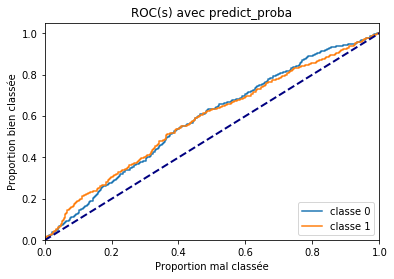

In [27]:
courbe_roc(Ytest,pred,y_proba)

La courbe ROC nous permet de confirmer le fait que la regression logistique n'est pas vraiment performante. En effet, on voit bien que les deux courbes sont très proches de la droite x=y ce qui signifie que lorsqu'on classe mal un individu, on a à peu près autant de chance de bien classé un autre individu de la même classe. Dans l'idéal, on aurait voulu que plus la proportion des individus mal classés est faible, plus la proportion d'individus bien classés est importante.

Calculons alors l'accuracy associée au modèle : 

In [28]:
print("Accuracy %.3f" % ((mat[0][0]+mat[1][1])/(mat[0][0]+mat[1][1] +mat[1][0]+mat[0][1])))

Accuracy 0.591


Cette valeur semble plutôt élevée en observant la confusion matrix pour la classe 0 (patients de contrôle) mais ceci est du au fait que le modèle semble prédire plus facilement l'appartenance à la classe 1 et que la proportion de schizophrène de l'échantillon est plus importante que celle de patients de contrôle.

La cross-validation sur les paramètres du modèle n'offrant pas de meilleurs résultats, effectuons alors une cross-validation sur les données et observons le taux de bonne prédiction sous forme de boxplot : 

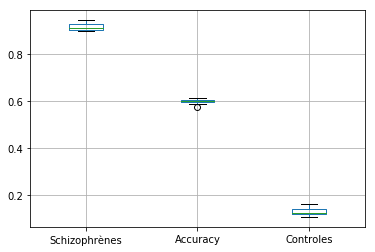

In [29]:
k=int(9)
n=int(len(X)/k)
res=pandas.DataFrame(columns=["nb trial","Schizophrènes","Controles","Accuracy","k"])
l=0
i=None
X = dataf.drop(['group','subject'],axis=1)
Y = dataf["group"]
cross_validation(l,k,n,i,X,Y,logreg,res)
res.boxplot(column=['Schizophrènes','Accuracy','Controles'])


On constate bien la bonne qualité de prédiction pour le groupe schizophrènes et la qualité de prédiction très faible plus réduite pour le groupe de contrôle. La précision totale (accuracy) ne dépassant pas les 60% de manière significative.

### Arbre de décision

In [30]:
tree=DecisionTreeClassifier() 
X = dataf.drop(["subject","group"],axis=1)
Y = dataf["group"]
mat2,Xtrain,Ytrain,Xtest,Ytest=model(X,Y,tree)
print(mat)

[[ 98 616]
 [109 950]]


Cette fois, la proportion de mal classé et bien classé semble plus proche pour les deux classes. Il est clair en revanche que la qualité de prédiction n'est pas satisfaisante.

 - 5-fold cross-validation sur les paramètres du modèle :

In [31]:
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeClassifier(),param,cv=5,n_jobs=-1)
tree_opt=tree.fit(Xtrain, Ytrain)
max_opt=tree_opt.best_params_

In [32]:
tree=DecisionTreeClassifier(max_depth=max_opt['max_depth'])
tree.fit(Xtrain, Ytrain)
pred = tree.predict(Xtest)
y_proba = tree.predict_proba(Xtest)
mat2bis = confusion_matrix(Ytest,pred)
print(mat2bis)

[[181 533]
 [219 840]]


La cross-validation des paramètres sur ce modèle apporte 100 % de bonnes prédictions pour les schizophrènes mais 0% pour le groupe de controle, ceci est dû aux proportions des deux groupes dans l'échantillon. La cross-validation sur les paramètres de l'arbre de décision ou d'une forêt d'arbres aléatoires n'est donc pas efficace. On récupère donc le modèle sans cross-validation. 

Traçons la courbe roc associée : 

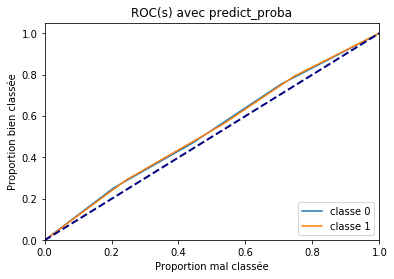

In [33]:
courbe_roc(Ytest,pred,y_proba)

Les deux courbes sont confondues avec l'axe y=x ce qui montre encore la mauvaise qualité prédictive de ce modèle.

In [34]:
print("Accuracy %.3f" % ((mat2[0][0]+mat2[1][1])/(mat2[0][0]+mat2[1][1] +mat2[1][0]+mat2[0][1])))

Accuracy 0.525


La précision totale est moins élevée que précedemment.

- Cross validation sur les données : 

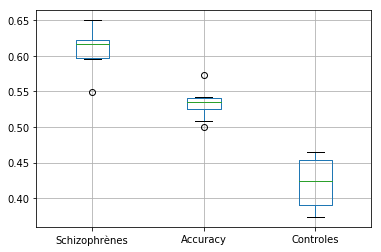

In [35]:
k=int(9)
n=int(len(X)/k)
result=pandas.DataFrame(columns=["nb trial","Schizophrènes","Controles","Accuracy","k"])
l=0
i=None
tree=DecisionTreeClassifier() 
X = dataf.drop(['group','subject'],axis=1)
Y = dataf["group"]
cross_validation(l,k,n,i,X,Y,tree,result)
result.boxplot(column=['Schizophrènes','Accuracy','Controles'])

Après cross validation, la précision de l'accuracy peut être optimisé jusqu'à 54 % environ.

### Forêt d'arbres aléatoires

Appliquons à présent un algorithme de forêts aléatoires :

In [36]:
clf = RandomForestClassifier()
X = dataf.drop(["subject","group"],axis=1)
Y = dataf["group"]
mat3,Xtrain,Xtest, Ytrain,Ytest = model(X,Y,clf)
print(mat3)

[[353 361]
 [411 648]]


Les résultats semblent analogues au modèle précédent.

Traçons les courbes ROC associées : 

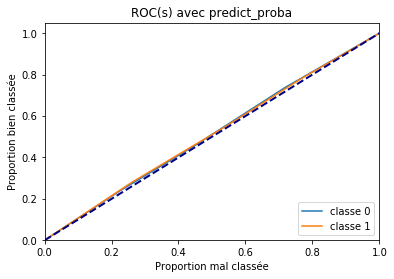

In [37]:
courbe_roc(Ytest,pred,y_proba)

On obtient ici encore deux courbes ROC très proches pour les deux classes et proches de la droite y=x ce qui confirme que les résultats fournis par le modèle randomForest ne sont pas satisfaisants. Ces courbes ROC sont plus éloignées de l'axe y=x que le modèle précédent ce qui nous aménerait à le privilégier.

Calculons l'accuracy associée : 

In [38]:
print("Accuracy %.3f" % ((mat3[0][0]+mat3[1][1])/(mat3[0][0]+mat3[1][1] +mat3[1][0]+mat3[0][1])))

Accuracy 0.565


Cette fois, l'accuracy est un peu plus élevé que pour le modèle précédent d'arbre de décision mais moins élevé que pour la régression logistique (toujours à cause du biais de prédiction soulevé dans la partie régression logistique).

Comme évoqué précédemment, la cross-validation sur les paramètres ne va pas fournir de résultats efficaces, on va donc directemment passer à la cross-validation sur les données : 

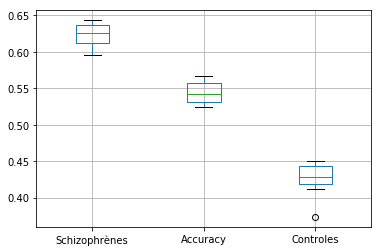

In [39]:
k=int(9)
n=int(len(X)/k)
result=pandas.DataFrame(columns=["nb trial","Schizophrènes","Controles","Accuracy","k"])
l=0
i=None
X = dataf.drop(['group','subject'],axis=1)
Y = dataf["group"]
cross_validation(l,k,n,i,X,Y,clf,result)
result.boxplot(column=['Schizophrènes','Accuracy',"Controles"])

Cette cross-validation ne semble pas augmenter de manière significative l'accuracy de notre modèle.

On peut alors conclure que la regression logistique n'est pas performante pour les données que nous avons et ne permet pas de fournir de bonnes prédictions. En effet, même si il y a peu de chances de se tromper si le patient est réellement schizophrène, la probabilité de prédire à un patient non schizophrène la schizophrènie est trop élevée (>70%).

L'arbre de décision et la forêt d'arbres aléatoires limitent les risques pour les patients de contrôle avec environ une chance sur deux de se tromper mais augmente la probabilité  de se tromper pour les patients atteints de schizophrénie avec également une chance sur deux d'erreur environ. Le modèle ne peut donc pas être considéré comme étant fiable pour la prédiction de la schizophrénie.

###  Réseaux de Neurones

Nous tentons d'appliquer alors différentes architectures de réseaux de neuronnes : 

- Un premier réseau Net1 composé d'une seule couche linéaire 
- Un second réseau Net2 composé de deux couches linéaires
- Un troisième réseau Net3 composé de deux couches linéaires mais sur lequel on applique après la première couche une tangente hyperbolique

#### Architecture 1

In [40]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
N_EPOCHS = 1000

In [41]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(12,2)
    
    def forward(self, x):
        x = self.fc1(x)
        return F.log_softmax(x)

In [42]:
model = Net1()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
X = dataf.drop(["subject","group"],axis=1)
X = X.astype("float32")
Y = dataf["group"]
X = X.as_matrix()
Y=Y.as_matrix()
Xtrain,Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)

In [43]:
mat, perfs = NN(Xtrain,Xtest,Ytrain,Ytest)
print(mat)

[[ 98 616]
 [ 88 971]]


Last accuracy 0.603
Best accuracy 0.606
Last test loss 0.6620


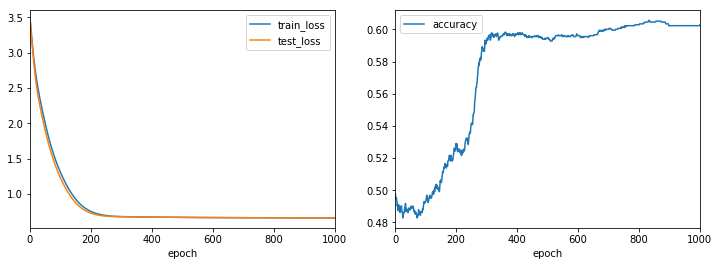

In [44]:
courbeNN(perfs)

#### Architecture 2

In [45]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(12, 20)
        self.fc2 = nn.Linear(20,2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [46]:
model = Net2()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
X = dataf.drop(["subject","group"],axis=1)
X = X.astype("float32")
Y = dataf["group"]
X = X.as_matrix()
Y=Y.as_matrix()
Xtrain,Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)

In [47]:
mat, perfs = NN(Xtrain,Xtest,Ytrain,Ytest)
print(mat)

[[ 91 623]
 [ 88 971]]


Last accuracy 0.599
Best accuracy 0.600
Last test loss 0.6629


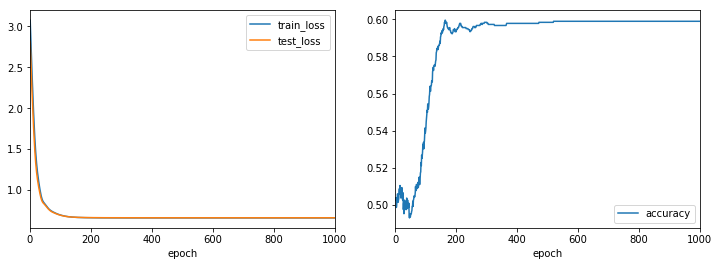

In [48]:
courbeNN(perfs)

#### Architecture 3

In [49]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(12, 20)
        self.fc2 = nn.Linear(20, 2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(self.fc2(x))
        return F.log_softmax(x)

In [50]:
model = Net3()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
X = dataf.drop(["subject","group"],axis=1)
X = X.astype("float32")
Y = dataf["group"]
X = X.as_matrix()
Y=Y.as_matrix()
Xtrain,Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)

In [51]:
mat, perfs = NN(Xtrain,Xtest,Ytrain,Ytest)
print(mat)

[[110 604]
 [122 937]]


Last accuracy 0.591
Best accuracy 0.601
Last test loss 0.6629


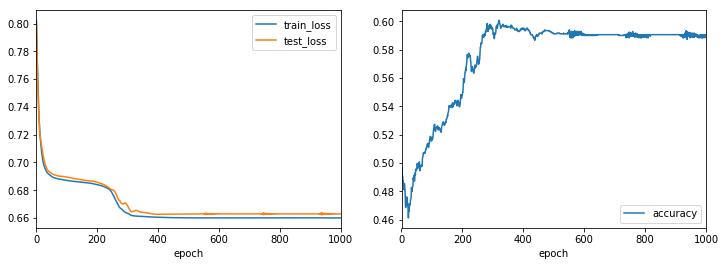

In [52]:
courbeNN(perfs)

##### Comparaison des 3 architectures

Afin de comparer ces 3 architectures, nous disposons de trois indicateurs : 
- Last accuracy
- Last test loss
- Vitesses de convergence 

<b>Last accuracy</b> : cet indicateur permet de fournir un taux de bonne prédiction. Pour les 3 réseaux de neurones, nous avons une valeur qui est assez proche avec un leger avantage pour les deux premières architectures.

<b>Last test loss</b> : cet indicateur est la dernière valeur obtenue pour la fonction de perte pour le dernier dataset de test. Pour les 3 modèles, les 3 valeurs sont très proches et ne nous permettent donc pas de differencier les réseaux.

<b>vitesses de convergence </b> : ici nous observons la vitesse de convergence pour les deux courbes précédentes. Pour la première architecture, la fonction de perte se stabilise à partir de 200 epoch environ et son accuracy à partir de 600 epoch. La seconde a sa fonction de perte se stabilisant à 100 epoch et à 400 epoch pour son accuracy. Enfin la troisième architecture offre des performances plus faibles : 400 epoch pour la stabilisation de la fonction de perte , 600-7000 pour l'accuracy.

En conclusion nous sommes amener à privilégier l'architecture 2 pour sa qualité de convergence, les taux de bonne prédiction n'étant pas significativement différents.

### Conclusion de l'étude basée sur l'avis médical

Il est clair qu'aucun des modèles n'offre une qualité de prédiction satisfaisante. 

En comparant les matrices de confusion, le modèle random forest permet tout de même d'obtenir les "meilleures" prédictions (environ 1 chance sur 2 d'erreur). 

En revanche, il est possible d'observer que les accuracy sont meilleures pour le modèle de regression logistique et les réseaux de neurones. Il est aussi clair que nos modèles prédisent plus souvent la schizophrénie et que notre dataset contient plus d'un tiers de schizophrènes en plus. Ceci peut facilement expliquer la meilleure qualité des accuracy pour ces modèles.

## Etudes libres

Comme évoqué dans la partie précédente, les études portant sur les données retraitées à partir des avis médicaux ne fournissent pas de résultats concluants. Nous allons alors avoir une approche plus "Machine Learning" du problème. Nous allons donc garder toutes les variables dont nous disposons ainsi que celles retraitées après avis médicaux et d'autres variables que nous introduirons.

Nous allons alors tenter deux approches : 
- Analyse de la variance (ANOVA)
- Analyse en composantes principales (ACP).

### Données et création de variables

On récupère la table de données avec les données pour chaque composante sur chaque électrode pour chaque condition ainsi que les données calculées pour l'étude basée sur l'avis des médecins.

In [53]:
datalibre = df3.copy()

On va introduire deux nouvelles variables "N100" et "P200" qui vont permettre de mesurer la différence d'amplitude entre les deux événements "Play Tone" et "Button Tone". D'après la figure 1-C, cette différence devrait être autour de 0 pour les schizophrènes et différente de 0 pour le groupe de contrôles.

De même, nous allons introduire de nouvelles variables "RP_P200" et "RP_N100" qui vont permettre de mesurer la différence d'amplitude entre l'hémisphère gauche et l'hémisphère droit uniquement pour l'évenement "Button Tone". D'après la figure 2-B, pour cette événement, la différence devrait être autour de 0 pour les schizophrènes et différente de 0 pour le groupe de contrôle.

De plus, nous décidons également de rajouter une variable binaire identifiée à partir de la figure 2-B qui va mesurer le fait que la valeur de RP_N100 pour l'hémisphère gauche est inférieure pour la condition "Button Tone" par rapport à la condition "Button Alone" pour un schizophrène.

In [54]:
datalibre["RP_N100_BIN"]=1
datalibre["RP_P200_BIN"]=1
for i in range(0,len(dataf)) :
    if datalibre.loc[i,"RP_N100_new1_L"]<datalibre.loc[i,"RP_N100_3_L"] :
        datalibre.loc[i,"RP_N100_BIN"] = 0
    if datalibre.loc[i,"RP_P200_new1_L"]<datalibre.loc[i,"RP_P200_3_L"]:
        datalibre.loc[i,"RP_P200_BIN"]=0
datalibre["RP_N100"] = datalibre["RP_N100_new1_R"]-datalibre["RP_N100_new1_L"]
datalibre["RP_P200"] = datalibre["RP_P200_new1_R"]-datalibre["RP_P200_new1_L"]
datalibre["N100"] = datalibre["N100_new1_moy"]-datalibre["N100_2_moy"]
datalibre["P200"] = datalibre["P200_new1_moy"]-datalibre["P200_2_moy"]

### Analyse de la variance (ANOVA)

On fait une analyse de la variance afin de mesurer la significativité des variables de notre dataset pour la variable "group" que l'on cherche à prédire.


Pour cela nous allons récupérer le dataset avec les amplitudes pour toutes les composantes (même celles de normalisation) par electrode et par condition auquel nous allons pouvoir rajouter toutes les variables calculées pour l'étude précédente. 

De plus, nous décidons également de rajouter les variables calculées précedemment.


In [55]:
dataANOVA = data.copy()
del dataANOVA['ITI']
del dataANOVA['rejected']

In [56]:
dataANOVA = pandas.melt(dataANOVA,id_vars=['subject','trial','condition'])
dataANOVA["variable"] = dataANOVA["variable"] + "_" + dataANOVA["condition"].map(str)
piv = dataANOVA.pivot_table(columns="variable",values="value",index=["subject","trial"])
piv = piv.dropna(how='any')
dfANOVA = pandas.DataFrame(piv.to_records())
dfANOVA = subinfo.merge(dfANOVA,left_on="subject",right_on="subject")
col = data.columns[5:]
for c in col :
    dfANOVA[c + "_new1"]=dfANOVA[c + "_1"] - dfANOVA[c + "_3"] 
dfANOVA = dfANOVA.drop(['gender','age','education','trial'],axis=1)
dfANOVA["N100_2_moy"] =df3["N100_2_moy"]
dfANOVA["N100_new1_moy"] = df3["N100_new1_moy"]
dfANOVA["P200_2_moy"] = df3["P200_2_moy"]
dfANOVA["P200_new1_moy"] = df3["P200_new1_moy"]
dfANOVA["RP_N100_new1_R"] = df3["RP_N100_new1_R"]
dfANOVA["RP_N100_new1_L"] =df3["RP_N100_new1_L"]
dfANOVA["RP_N100_3_R"] = df3["RP_N100_3_R"]
dfANOVA["RP_N100_3_L"] =df3["RP_N100_3_L"]
dfANOVA["RP_P200_new1_R"] = df3["RP_P200_new1_R"]
dfANOVA["RP_P200_new1_L"] = df3["RP_P200_new1_L"] 
dfANOVA["RP_P200_3_R"] = df3["RP_P200_3_R"] 
dfANOVA["RP_P200_3_L"] = df3["RP_P200_3_L"]
dfANOVA["RP_N100"] = dfANOVA["RP_N100_new1_R"]-dfANOVA["RP_N100_new1_L"]
dfANOVA["RP_P200"] = dfANOVA["RP_P200_new1_R"]-dfANOVA["RP_P200_new1_L"]
dfANOVA["N100"] = dfANOVA["N100_new1_moy"]-dfANOVA["N100_2_moy"]
dfANOVA["P200"] = dfANOVA["P200_new1_moy"]-dfANOVA["P200_2_moy"]
dfANOVA["RP_N100_BIN"]=datalibre["RP_N100_BIN"]
dfANOVA["RP_P200_BIN"]=datalibre["RP_P200_BIN"]

Nous allons alors chercher les variables les plus significatives pour expliquer la variable "group" au seuil de 5 % en appliquant un ANOVA : 

In [57]:
formula = 'group ~ C3_N100_1+C3_N100_2 + C3_N100_3 + C3_N100_new1+C3_P200_1+C3_P200_2 + C3_P200_3 + C3_P200_new1+\
C4_P200_1 +C4_P200_2 + C4_P200_3 + C4_P200_new1+C4_N100_1 + C4_N100_2 + C4_N100_3 + C4_N100_new1+ \
CP3_N100_1+CP3_N100_2 +CP3_N100_3 +CP3_N100_new1+ CP3_P200_1 + CP3_P200_2 + CP3_P200_3 + CP3_P200_new1+\
CP4_N100_1+CP4_N100_2 + CP4_N100_3 + CP4_N100_new1+CP4_P200_1+ CP4_P200_2 + CP4_P200_3 + CP4_P200_new1+\
Cz_N100_1 +Cz_N100_2 + Cz_N100_3 +Cz_N100_new1 +Cz_P200_1+Cz_P200_2 + Cz_P200_3 + Cz_P200_new1+\
FC3_N100_1 + FC3_N100_2 + FC3_N100_3 + FC3_N100_new1 + FC3_P200_1+FC3_P200_2 + FC3_P200_3 + FC3_P200_new1+\
FC4_N100_1+FC4_N100_2 + FC4_N100_3 + FC4_N100_new1+FC4_P200_1 +FC4_P200_2 +FC4_P200_3 + FC4_P200_new1+ \
FCz_N100_1 + FCz_N100_2 + FCz_N100_3 +FCz_N100_new1 + FCz_P200_1 +FCz_P200_2 + FCz_P200_3 + FCz_P200_new1 +\
Fz_N100_1+ Fz_N100_2 + Fz_N100_3 + Fz_N100_new1+Fz_P200_1+Fz_P200_2 + Fz_P200_3 + Fz_P200_new1+\
C3_B0_1+C3_B0_2+C3_B0_3+C3_B1_1+C3_B1_2+C3_B1_3+C3_B0_new1+C3_B1_new1+C4_B0_1+C4_B0_2+C4_B0_3+C4_B1_1+C4_B1_2+C4_B1_3+C4_B0_new1+C4_B1_new1+\
CP3_B0_1+CP3_B0_2+CP3_B0_3+CP3_B1_1+CP3_B1_2+CP3_B1_3+CP3_B0_new1+CP3_B1_new1+CP4_B0_1+CP4_B0_2+CP4_B0_3+CP4_B1_1+CP4_B1_2+CP4_B1_3+\
CP4_B0_new1+CP4_B1_new1+FC4_B0_1+FC4_B0_2+FC4_B0_3+FC4_B1_1+FC4_B1_2+FC4_B1_3+FC4_B0_new1+FC4_B1_new1+FC3_B0_1+FC3_B0_2+FC3_B0_3+\
FC3_B1_1+FC3_B1_2+FC3_B1_3+FC3_B0_new1+FC3_B1_new1+FCz_B0_1+FCz_B0_2+FCz_B0_3+FCz_B1_1+FCz_B1_2+FCz_B1_3+FCz_B0_new1+FCz_B1_new1+\
Cz_B0_1+Cz_B0_2+Cz_B0_3+Cz_B1_1+Cz_B1_2+Cz_B1_3+Cz_B0_new1+Cz_B1_new1+Fz_B0_1+Fz_B0_2+FCz_B0_3+Fz_B1_1+Fz_B1_2+Fz_B1_3+Fz_B0_new1+Fz_B1_new1+\
N100_2_moy+N100_new1_moy+P200_2_moy+P200_new1_moy+RP_N100_new1_R+RP_N100_new1_L+RP_N100_3_R+RP_N100_3_L+RP_P200_new1_R+RP_P200_new1_L+\
RP_P200_3_R+RP_P200_3_L+RP_N100+RP_P200+N100+P200+RP_P200_BIN+RP_N100_BIN'
model = ols(formula, dfANOVA).fit()
aov_table = anova_lm(model, typ=2)

In [58]:
print(aov_table)

                     sum_sq      df          F    PR(>F)
C3_N100_1          0.047979     1.0   0.207652  0.648628
C3_N100_2          0.395045     1.0   1.709764  0.191059
C3_N100_3          0.001957     1.0   0.008468  0.926683
C3_N100_new1       0.167373     1.0   0.724392  0.394736
C3_P200_1          0.632001     1.0   2.735314  0.098197
C3_P200_2          1.782891     1.0   7.716393  0.005487
C3_P200_3          0.052658     1.0   0.227907  0.633095
C3_P200_new1       0.744444     1.0   3.221968  0.072699
C4_P200_1          0.000586     1.0   0.002535  0.959843
C4_P200_2          0.437270     1.0   1.892514  0.168963
C4_P200_3          0.006667     1.0   0.028854  0.865122
C4_P200_new1       0.028403     1.0   0.122929  0.725890
C4_N100_1          0.419543     1.0   1.815791  0.177859
C4_N100_2          1.402910     1.0   6.071825  0.013759
C4_N100_3          0.347447     1.0   1.503760  0.220135
C4_N100_new1       0.004983     1.0   0.021565  0.883255
CP3_N100_1         0.059579    

On obtient alors un tableau sur lequel nous allons chercher à identifier les variables significatives au seuil de 5% à l'aide de la p-value. 

On obtient la liste de variables suivantes à garder : C3_P200_2, C4_N100_2, CP3_P200_1,CP3_P200_2, Cz_N100_2,Cz_P200_2, FC4_N100_1, FC4_N100_new1, FC4_P200_1, FC4_P200_new1, FCz_N100_2, FCz_P200_2, Fz_N100_2, Fz_P200_2, C3_B0_1, C3_B0_3, C4_B1_new1, FC4_B0_2, FC4_B1_new1, FCz_B0_2, Cz_B0_2, N100_2_moy, P200_2_moy, RP_N100_new1_R, RP_P200_new1_R, RP_P200_3_R, RP_P200.

On va donc tester le modèle de regression logistique sur ces nouvelles variables : 

In [59]:
logreg = LogisticRegression()
X = dfANOVA[['C3_P200_2', 'C4_N100_2','CP3_P200_1','CP3_P200_2','Cz_N100_2','Cz_P200_2','FC4_N100_1',
            'FC4_N100_new1','FC4_P200_1','FC4_P200_new1','FCz_N100_2','FCz_P200_2','Fz_N100_2','Fz_P200_2',
            'C3_B0_1','C3_B0_3','C4_B1_new1','FC4_B0_2','FC4_B1_new1','FCz_B0_2','Cz_B0_2','N100_2_moy',
            'P200_2_moy','RP_N100_new1_R','RP_P200_new1_R','RP_P200_3_R','RP_P200']]
Y = dfANOVA["group"]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)
logreg.fit(Xtrain,Ytrain)
pred = logreg.predict(Xtest)
mat1 = confusion_matrix(Ytest,pred)
print(mat1)

[[115 599]
 [120 939]]


D'après la confusion matrix obtenue, les résultats semblent légèrement meilleurs que la regression logistique de l'étude précédente mais les résultats ne sont toujours pas satisfaisants. On décide donc alors de s'intéresser aux corrélations entre variables à l'aide d'une analyse en composantes principales afin de voir si il est possible d'obtenir de meilleurs résultats.

### Analyse en composantes principales

L'Analyse en composantes principales est une stratégie efficace en traitement du signal. 

Nous allons donc l'appliquer ici sur nos variables du dataset "datalibre".

#### Mise en place

In [60]:
# On pense à mélanger nos données :
datalibre = sklearn.utils.shuffle(datalibre).reset_index().drop("index",axis=1)
# On choisit les 10 premières composantes principales
pca = PCA(n_components=10)
# On retire bien sur les colonnes "group" (pour des raisons évidentes) et "subject" pour éviter l'overfiting 
dfA = datalibre.drop(['group','subject'], axis=1)
dfA = sklearn.preprocessing.scale(dfA)
dfA = pandas.DataFrame(dfA)
datalibre_res = pca.fit_transform(dfA,1)
pca.explained_variance_ratio_

array([ 0.2933871 ,  0.13499423,  0.09435499,  0.08831099,  0.0590538 ,
        0.05502472,  0.05315592,  0.0483644 ,  0.01763302,  0.01568884])

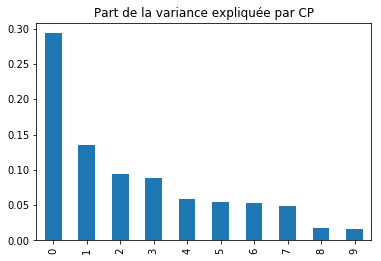

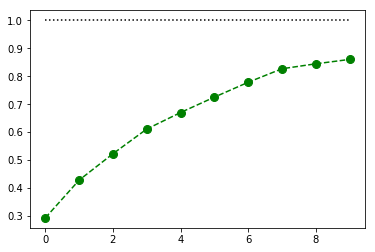

In [61]:
plt.figure()
scree = pandas.Series(pca.explained_variance_ratio_)
scree.plot(kind='bar', title=u"Part de la variance expliquée par CP")
plt.figure()
cum = scree.cumsum()
plt.plot(range(cum.size),cum,'o--', markersize=8, color='green')
plt.plot(range(cum.size),numpy.ones(cum.size),':',  color='black')

Nous avons ici considéré les 10 premières composantes principales. D'après les figures ci-dessus, ceci nous permet d'obtenir en 10 variables (au lieu de 75) plus de 80% de la variance totale de nos données.

In [62]:
A= pandas.DataFrame(datalibre_res)
A["group"]= datalibre["group"]
A["subject"]= datalibre["subject"]

In [63]:
A.head()

,0,1,2,3,4,5,6,7,8,9,group,subject
0,-0.993505,0.448845,2.158064,2.085442,2.036855,-0.467522,-1.940472,-0.946206,-0.012963,1.471183,0,2
1,4.349239,-2.411882,4.068803,0.426159,-2.110679,-1.092166,1.405048,-1.467143,-2.933268,-0.946386,1,69
2,12.225630,5.540751,1.435076,-1.103429,-1.399587,0.374633,1.791899,-0.955467,1.947254,-1.675859,0,59
3,-0.141454,7.757287,-0.450468,-0.018991,0.770128,0.349024,3.161005,-1.308901,1.535374,0.767962,1,38
4,-2.654809,0.553166,-0.850076,-4.600193,0.483246,0.640143,1.325343,-0.005991,-0.525710,0.776505,0,14


Nous allons alors, avec nos nouvelles données projetées selon les 10 premières composantes principales, tenter d'effectuer à nouveau une prédiction.

#### Prédiction avec nouvelles variables

##### Régression logistique : 

In [64]:
logreg = LogisticRegression()
X = A.drop(["group","subject"],axis=1)
Y = A["group"]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)
logreg.fit(Xtrain,Ytrain)
pred = logreg.predict(Xtest)
y_proba = logreg.predict_proba(Xtest)
mat1 = confusion_matrix(Ytest,pred)
print(mat1)

[[107 607]
 [ 97 962]]


Nous avons à nouveau le même biais de prédiction : les patients de contrôle sont mal prédits alors que les patients "schizophrènes" sont plutôt bien prédits comme tels.

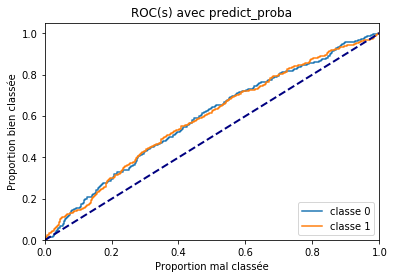

In [65]:
courbe_roc(Ytest,pred,y_proba)

In [66]:
seuil_rl = (mat1[0][0]+mat1[1][1])/(mat1[0][0]+mat1[1][1] +mat1[1][0]+mat1[0][1])
print("Accuracy %.3f" % seuil_rl)

Accuracy 0.603


Les courbes ROC et l'accuracy associées sont comparables aux résultats de l'étude précédente.

##### Arbre de décision : 

In [67]:
tree=DecisionTreeClassifier() 
X = A.drop(["group","subject"],axis=1)
Y = A["group"]
Xtrain,Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)
tree.fit(Xtrain,Ytrain)
pred = tree.predict(Xtest)
y_proba = tree.predict_proba(Xtest)
mat2 = confusion_matrix(Ytest,pred)
print(mat2)

[[328 386]
 [410 649]]


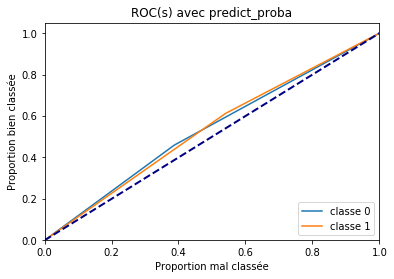

In [68]:
courbe_roc(Ytest,pred,y_proba)

In [69]:
seuil_dt = (mat2[0][0]+mat2[1][1])/(mat2[0][0]+mat2[1][1] +mat2[1][0]+mat2[0][1])
print("Accuracy %.3f" % seuil_dt)

Accuracy 0.551


Les courbes ROC et la précision sont  ici encore non satisfaisantes pour ce modèle.

###### Forêt d'arbres aléatoires : 

In [70]:
clf = RandomForestClassifier()
X = A.drop(["group","subject"],axis=1)
Y = A["group"]
Xtrain,Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)
clf.fit(Xtrain,Ytrain)
pred = clf.predict(Xtest)
y_proba = clf.predict_proba(Xtest)
mat3 = confusion_matrix(Ytest,pred)
print(mat3)

[[346 368]
 [428 631]]


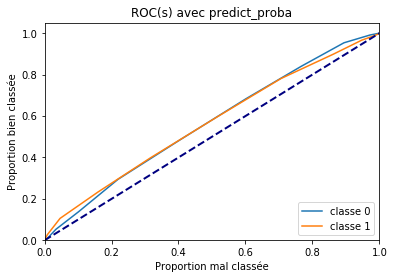

In [71]:
courbe_roc(Ytest,pred,y_proba)

In [72]:
seuil_rf = (mat3[0][0]+mat3[1][1])/(mat3[0][0]+mat3[1][1] +mat3[1][0]+mat3[0][1])
print("Accuracy %.3f" % seuil_rf)

Accuracy 0.551


Les résultats obtenus ici sont très proches de ceux du modèle d'arbre de décision. On notera quand même une légère amélioration de la précision de prédiction ainsi qu'un meilleur comportement des courbes ROC. Cela reste toujours comparable aux résultats obtenus avec l'étude précédente.

##### Réseau de neurones : 

Nous allons uniquement reprendre ici l'architecture 2. Il est nécessaire de modifier l'entrée de nos réseaux de neuronnes. En effet l'étude précédente comportait 12 variables contre 10 à présent.

In [73]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20,2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [74]:
model = Net2()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
X = A.drop(['group',"subject"],axis=1)
X = X.astype("float32")
Y = A["group"]
X = X.as_matrix()
Y=Y.as_matrix()
Xtrain,Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)

In [75]:
mat, perfs = NN(Xtrain,Xtest,Ytrain,Ytest)
print(mat)

[[ 98 616]
 [107 952]]


Last accuracy 0.592
Best accuracy 0.593
Last test loss 0.6646


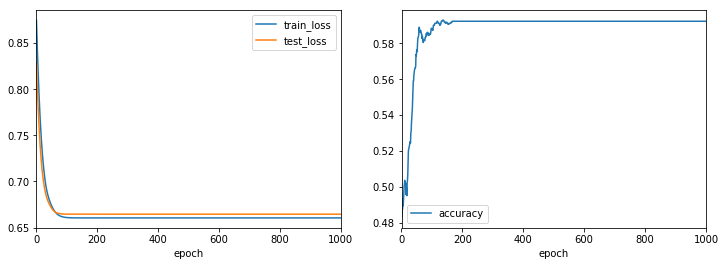

In [76]:
courbeNN(perfs)

Ce dernier modèle offre des résultats de prédiction assez proche de la régression logistique et converge rapidement en terme d'accuracy.

Il semble que ni la sélection de variables avec ANOVA ni la projection de nos variables selon les composantes principales de  l'ACP ne nous permettent d'améliorer la qualité de nos prédictions de manière significative.

## Evaluation du nombre d'essais cliniques nécessaires

Enfin, la dernière partie va concerner l'étude du nombre d'essais cliniques. En effet, nous savons que chaque patient réalise plusieurs dizaines de fois les trois expériences. Nous avons alors décidé d'évaluer pour chacun de ces modèles le nombre d'essais cliniques ("trial") minimum nécessaires par patient pour avoir une "bonne qualité de prédiction". Nous allons réaliser cela avec les données transformées par l'ACP car elles ont des performances comparables à celles issues de l'avis médical avec un nombre de variables plus réduits.

### Analyse des données disponibles

Dans un premier temps, nous allons regarder le nombre de trial dont on dispose par individu (après suppression des essais rejetés) puis on regarde alors le minimum obtenu :

In [77]:
datalibre["nb"]=1
nb = datalibre[["subject","nb"]].groupby("subject").count()
min(nb["nb"])
nb.loc[min(nb['nb'])==nb['nb']]

,nb
subject,
51,14


On obtient 14 ce qui est tout de même un nombre faible sur les 100 "potentiels" par individu. On regarde alors le résultat obtenu si on supprime l'individu pour lequel on dispose uniquement de 14 essais puis on répète alors l'opération afin d'obtenir un nombre d'essais possibles plus important.

In [78]:
nb2 = nb.loc[~(nb["nb"]==min(nb["nb"]))]
#on supprime le premier outlier qui n'a fait que 14 essais (le sujet 51)
datalibre2 = datalibre.loc[~(datalibre["subject"]==51)]
for i in range(52,82) : 
    datalibre2.loc[datalibre2["subject"]==i,"subject"]=i-1
nb2.loc[min(nb2['nb'])==nb2['nb']]

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nb
subject,
31,42


In [79]:
nb3 = nb2.loc[~(nb2["nb"]==min(nb2["nb"]))]
datalibre3 = datalibre2.loc[~(datalibre2["subject"]==31)]
for i in range(32,81) : 
    datalibre3.loc[datalibre3["subject"]==i,"subject"]=i-1
nb3.loc[min(nb3['nb'])==nb3['nb']]

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nb
subject,
32,77


On va alors décider de regarder les trois sets de données ci-dessus.  : 

In [80]:
datalibreB = datalibre2.drop(['group','subject'], axis=1)
datalibreB = sklearn.preprocessing.scale(datalibre2)
datalibreB = pandas.DataFrame(datalibreB)
datalibre2_res = pca.fit_transform(datalibreB,1)
pca.explained_variance_ratio_
B= pandas.DataFrame(datalibre2_res)
B["group"]= datalibre2["group"]
B["subject"] = datalibre2["subject"]

In [81]:
datalibreC = datalibre3.drop(['group','subject'], axis=1)
datalibreC = sklearn.preprocessing.scale(datalibre3)
datalibreC = pandas.DataFrame(datalibreC)
datalibre3_res = pca.fit_transform(datalibreC,1)
pca.explained_variance_ratio_
C= pandas.DataFrame(datalibre3_res)
C["group"]= datalibre3["group"]
C["subject"] = datalibre3["subject"]
A["subject"]=datalibre["subject"]

### Prédiction en fonction du nombre d'essais cliniques

Afin de pouvoir prédire un modèle de type regression logistique ou random forest en fonction du nombre d'essais, on utilise la fonction définie ci-dessous. 

Cette fonction permet de générer un dataframe contenant respectivement le taux de réussite pour les patients de contrôle ainsi que pour les schizophrènes et l'accuracy du modèle en fonction du nombre de trials. On effectue une cross-validation afin d'être plus précis et on obtient donc plusieurs valeurs par nombre d'essais. 

On lui donne en entrées le nombre de sujets, le nombre d'essais maximum, le tableau de données et un modèle de machine learning.

In [82]:
def eval_trial(Nsubj,N,df,model) : 
    result = pandas.DataFrame(columns=["nb trial","Schizophrènes","Controles","Accuracy","k"])
    l=0
    #on récupère les i premiers essais pour chaque patient pour tous les nombres d'essais possibles
    #1 à N
    for i in range(1,N):
        subset=pandas.DataFrame()
        for subj in range(1,(Nsubj+1)) :
            df_subj = df.loc[df["subject"]==subj][0:i]
            subset=pandas.concat((subset,df_subj)) 
        #on mélange les lignes de notre dataset car les sujets sont triés
        subset = sklearn.utils.shuffle(subset)
        subset = subset.reset_index()
        subset = subset.drop("subject",axis=1)
        X = subset.drop(["index","group"],axis=1)
        Y = subset["group"]
        #cross validation
        k=10
        while ((i*Nsubj) % k != 0):
            k=k-1
        n = int(((i)*Nsubj)/k)
        #on isole le cas où le dataset n'est pas divisible par un nombre < à 10
        if k ==1 :
            Xtrain,Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)
            model.fit(Xtrain,Ytrain)
            pred = model.predict(Xtest)
            mat = confusion_matrix(Ytest,pred)
            # comme nous ne disposons pas de beaucoup de données on vérifie que le set de test
            # est bien composé de patients de contrôles et de patients schizophrènes sinon
            # il ne faudra pas prendre en compte le résultat obtenu
            if len(mat)==1 :
                if Ytest.loc[0]["group"]==0 :
                    result.loc[l] = [i,None,1,None,k]
                else : result.loc[l] = [i,1,None,None,k]
            else : result.loc[l] = [i,mat[1][1]/(mat[1][0]+mat[1][1]),mat[0][0]/(mat[0][0]+mat[0][1]),
                                    ((mat[0][0]+mat[1][1])/(mat[0][0]+mat[1][1] +mat[1][0]+mat[0][1])),k]
            l=l+1
        else :
            for j in range(0,k) :
                Xtest =X.loc[n*j:(n*(j+1))-1]
                Ytest = Y.loc[n*j:(n*(j+1))-1]
                Xtrain = X.drop(range(n*j,n*(j+1)),axis=0)
                Ytrain = Y.drop(range(n*j,n*(j+1)),axis=0)
                model.fit(Xtrain,Ytrain)
                pred = model.predict(Xtest)
                mat = confusion_matrix(Ytest,pred)
                if len(mat)==1 :
                    if Ytest.loc[0]["group"]==0 :
                        result.loc[l] = [i,None,1,None,j+1]
                    else : result.loc[l] = [i,1,None,None,j+1]
                else : result.loc[l] = [i,mat[1][1]/(mat[1][0]+mat[1][1]),mat[0][0]/(mat[0][0]+mat[0][1]),
                                        ((mat[0][0]+mat[1][1])/(mat[0][0]+mat[1][1] +mat[1][0]+mat[0][1])),j+1]
                l=l+1
    return (result)

Nous définissons également une fonction courbes_accuracy qui, à partir des sorties d'eval_trial vont tracer les courbes min max et moyennes des accuracy en fonction du nombre d'essais cliniques sur nos cross-validation : 

In [83]:
def courbes_accuracy(result):
    cb_min = []
    cb_max = []
    cb_mean = []
    for j in range(1,int(max(result["nb trial"]))):
        temp = result.loc[result["nb trial"]==j]
        cb_min.append(min(temp["Accuracy"]))
        cb_max.append(max(temp["Accuracy"]))
        cb_mean.append(numpy.mean(temp["Accuracy"]))
    plt.figure()
    plt.plot(cb_min,label="Courbe Accuracy min")
    plt.plot(cb_max,label="Courbe Accuracy max")
    plt.plot(cb_mean,label="Courbe Accuracy moyenne")
    plt.ylabel(u"Accuracy")
    plt.xlabel(u"Nombres d'essais cliniques")
    plt.legend(loc=1)

#### Régression logistique

On va effectuer une régression logistique pour les 3 sets de données obtenus à la suite des ACP (A,B,C).

In [84]:
result1 = eval_trial(len(nb),min(nb["nb"]),A,logreg)
result2 =eval_trial(len(nb2),min(nb2["nb"]),B,logreg)
result3 =eval_trial(len(nb3),min(nb3["nb"]),C,logreg)

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f8746d8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a1b38c080>], dtype=object)

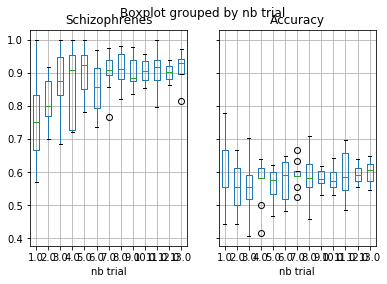

In [85]:
result1.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

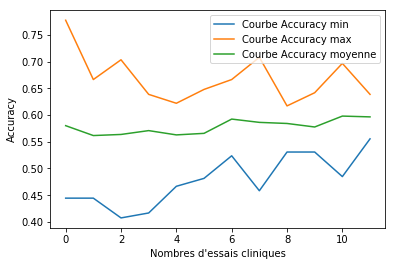

In [86]:
courbes_accuracy(result1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ce28320>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a1c6ed2e8>], dtype=object)

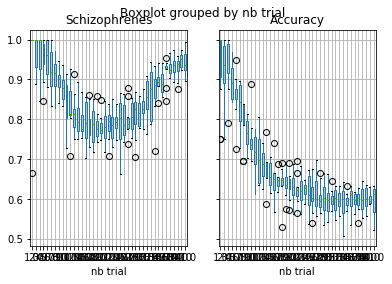

In [87]:
result2.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

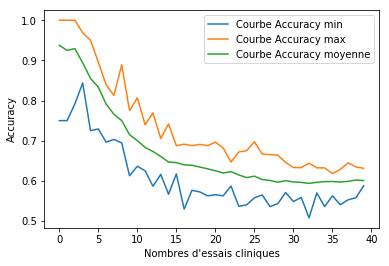

In [88]:
courbes_accuracy(result2)

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d9beb70>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a1da1df60>], dtype=object)

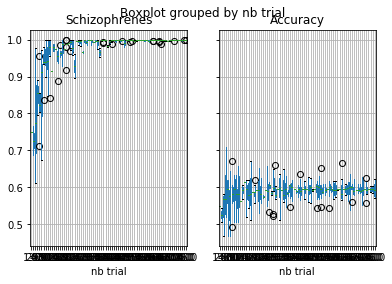

In [89]:
result3.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

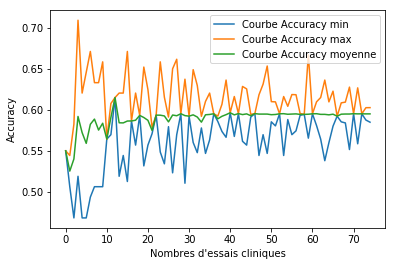

In [90]:
courbes_accuracy(result3)

Pour ce modèle, la valeur de notre accuracy semble commencer à se stabiliser à partir de 25 essais avec une stabilisation plus nette à partir de 50 essais.

#### Arbre de décision

In [91]:
result1 = eval_trial(len(nb),min(nb["nb"]),A,tree)
result2 =eval_trial(len(nb2),min(nb2["nb"]),B,tree)
result3 =eval_trial(len(nb3),min(nb3["nb"]),C,tree)

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2960fa20>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a29600908>], dtype=object)

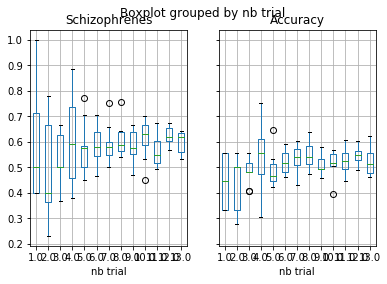

In [92]:
result1.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

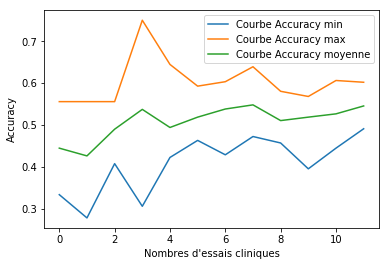

In [93]:
courbes_accuracy(result1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a299abd30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a299b2860>], dtype=object)

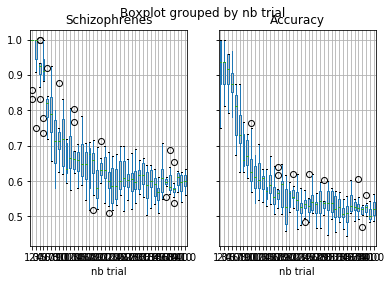

In [94]:
result2.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

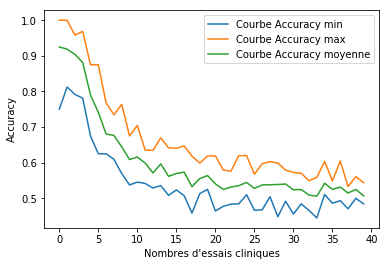

In [95]:
courbes_accuracy(result2)

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2a54cfd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a29b51550>], dtype=object)

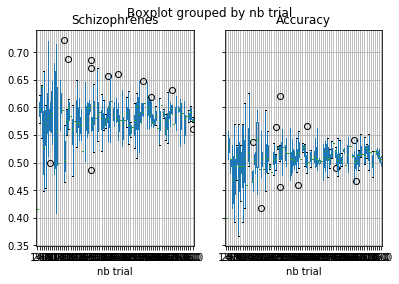

In [96]:
result3.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

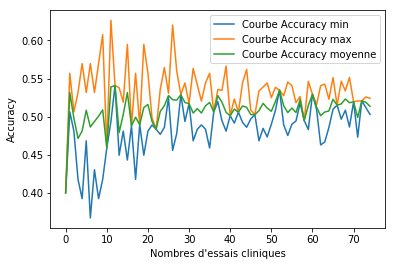

In [97]:
courbes_accuracy(result3)

Ici, la valeur de notre accuracy offre une stabilisation bien moins nette. Un semblant de stabilisation apparaît à partir d'une trentaine de trials.

#### Forêt d'arbres aléatoires

In [98]:
result1 = eval_trial(len(nb),min(nb["nb"]),A,clf)
result2 =eval_trial(len(nb2),min(nb2["nb"]),B,clf)
result3 =eval_trial(len(nb3),min(nb3["nb"]),C,clf)

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a29b2f748>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a2ae529b0>], dtype=object)

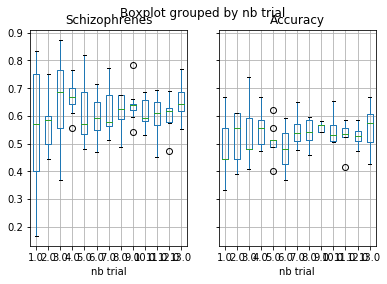

In [99]:
result1.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

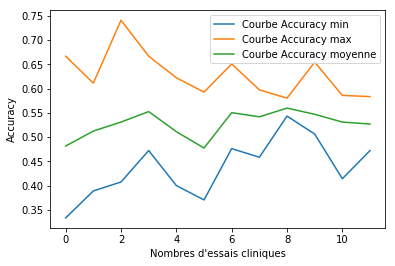

In [100]:
courbes_accuracy(result1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2c20e588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a2af9e8d0>], dtype=object)

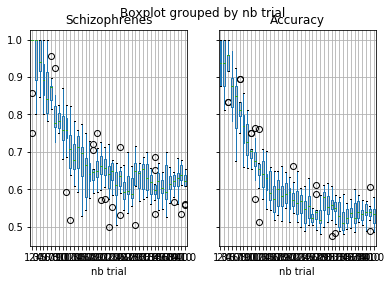

In [101]:
result2.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

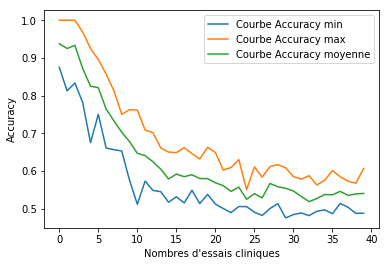

In [102]:
courbes_accuracy(result2)

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2b845a90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a2b883a20>], dtype=object)

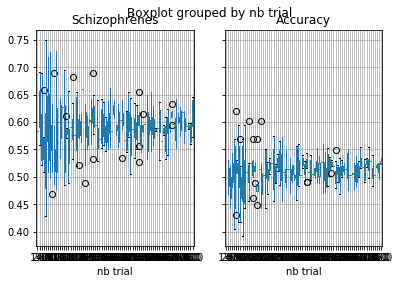

In [103]:
result3.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

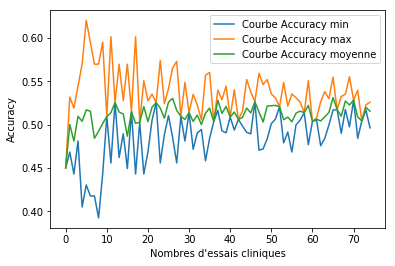

In [104]:
courbes_accuracy(result3)

Comme lors de notre étude, le comportement des modèles forêts aléatoires et d'arbre de décision offrent ici encore des résultats analogues. On ne constate pas de réelles stabilisation de l'accuracy.

#### Réseaux de neurones

Pour les réseaux de neurones, il est nécessaire d'adapter un peu la fonction eval_trial : 

In [105]:
def eval_trial_NN(Nsubj,N,df,model) : 
    result = pandas.DataFrame(columns=["nb trial","Schizophrènes","Controles","Accuracy","k"])
    l=1
    #on récupère les i premiers essais pour chaque patient pour tous les nombres d'essais possibles
    #1 à N
    for i in range(1,N):
        subset=pandas.DataFrame()
        for subj in range(1,(Nsubj+1)) :
            df_subj = df.loc[df["subject"]==subj][0:i]
            subset=pandas.concat((subset,df_subj)) 
        #on mélange les lignes de notre dataset car les sujets sont triés
        subset = sklearn.utils.shuffle(subset)
        subset = subset.reset_index()
        subset = subset.drop("subject",axis=1)
        X = subset.drop(["index","group"],axis=1)
        X = X.astype("float32")
        Y = subset["group"]
        X = X.as_matrix()
        Y=Y.as_matrix()
        #cross validation
        k=10
        while ((i*Nsubj) % k != 0):
            k=k-1
        n = int(((i)*Nsubj)/k)
        #on isole le cas où le dataset n'est pas divisible par un nombre < à 10
        if k ==1 :
            optimizer = optim.Adam(model.parameters())
            loss_fn = nn.NLLLoss()
            Xtrain,Xtest, Ytrain, Ytest = train_test_split(X,Y,stratify=Y,test_size=0.25)
            Xtrain_ = Variable(torch.from_numpy(Xtrain))
            Xtest_ = Variable(torch.from_numpy(Xtest))
            Ytrain_ = Variable(torch.from_numpy(Ytrain)).long()
            Ytest_ = Variable(torch.from_numpy(Ytest)).long()
            for t in range(1, N_EPOCHS + 1):
                optimizer.zero_grad()
                Ypred=model(Xtrain_)
                loss = loss_fn(Ypred , Ytrain_)
                loss.backward()
                optimizer.step()
                Ypred_test = model(Xtest_)
                loss_test = loss_fn(Ypred_test, Ytest_)
                pred = Ypred_test.data.max(1, keepdim=True)[1] 
            pred = Ypred_test.data.max(1, keepdim=True)[1] 
            pred = pred.numpy()
            dY = pandas.DataFrame(Ytest,dtype='float')
            dYpretest = pandas.DataFrame(pred,dtype="float")
            mat=confusion_matrix(dY,dYpretest)
            if len(mat)==1 :
                if Ytest[0]==0 :
                    result.loc[l] = [i,None,1,None,k]
                else : result.loc[l] = [i,1,None,None,k]
            else : result.loc[l] = [i,mat[1][1]/(mat[1][0]+mat[1][1]),mat[0][0]/(mat[0][0]+mat[0][1]),
                                    ((mat[0][0]+mat[1][1])/(mat[0][0]+mat[1][1] +mat[1][0]+mat[0][1])),k]
            l=l+1
        else :
            for j in range(0,k) :
                a=int(n*j)
                b=int(n*(j+1)-1)
                Xtest =X[a:b,:]
                Ytest = Y[a:b]
                subset2 = subset.drop(range(n*j,n*(j+1)),axis=0)
                Xtrain = subset2.drop(["index","group"],axis=1)
                Xtrain = Xtrain.astype("float32")
                Ytrain = subset2["group"]
                Xtrain=Xtrain.as_matrix()
                Ytrain=Ytrain.as_matrix()
                optimizer = optim.Adam(model.parameters())
                loss_fn = nn.NLLLoss()
                Xtrain_ = Variable(torch.from_numpy(Xtrain))
                Xtest_ = Variable(torch.from_numpy(Xtest))
                Ytrain_ = Variable(torch.from_numpy(Ytrain)).long()
                Ytest_ = Variable(torch.from_numpy(Ytest)).long()
                for t in range(1, N_EPOCHS + 1):
                    optimizer.zero_grad()
                    Ypred = model(Xtrain_)
                    loss = loss_fn(Ypred , Ytrain_)
                    loss.backward()
                    optimizer.step()
                    Ypred_test = model(Xtest_)
                    loss_test = loss_fn(Ypred_test, Ytest_)
                    pred = Ypred_test.data.max(1, keepdim=True)[1] 
                pred = Ypred_test.data.max(1, keepdim=True)[1] 
                pred = pred.numpy()
                dY = pandas.DataFrame(Ytest,dtype='float')
                dYpretest = pandas.DataFrame(pred,dtype="float")
                mat=confusion_matrix(dY,dYpretest)
                if len(mat)==1 :
                    if Ytest[0]==0 :
                        result.loc[l] = [i,None,1,None,j+1]
                    else : result.loc[l] = [i,1,None,None,j+1]
                else : result.loc[l] = [i,mat[1][1]/(mat[1][0]+mat[1][1]),mat[0][0]/(mat[0][0]+mat[0][1]),
                                        ((mat[0][0]+mat[1][1])/(mat[0][0]+mat[1][1] +mat[1][0]+mat[0][1])),j+1]
                l=l+1
    return (result)

Pour alléger le temps de calcul et en nous basant sur le comportement étudié précedemment des réseaux de neuronnes, nous réduisons à présent le nombre d'epoch à 500. De plus nous allons uniquement considérer l'architecture 2 pour ne pas multiplier le nombre de calculs : 

In [106]:
N_EPOCHS = 500

In [107]:
model2 = Net2()

In [108]:
result2NNA=eval_trial_NN(len(nb),min(nb["nb"]),A,model2)
result2NNB=eval_trial_NN(len(nb2),min(nb2["nb"]),B,model2)
result2NNC=eval_trial_NN(len(nb3),min(nb3["nb"]),C,model2)

/Users/lemeurvincent/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:91: RuntimeWarning: invalid value encountered in long_scalars


KeyboardInterrupt: 

In [ ]:
result2NNA.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

In [ ]:
courbes_accuracy(result2NNA)

In [ ]:
result2NNB.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

In [ ]:
courbes_accuracy(result2NNB)

In [ ]:
result2NNC.boxplot(column=['Schizophrènes','Accuracy'],by='nb trial')

In [ ]:
courbes_accuracy(result2NNC)

Les résultats sont proches de ceux obtenus pour la régression logistique avec une stabilisation autour d'une trentaine de trials ce qui pourraient être le nombre d'essais cliniques optimal à réaliser pour ce modèle.

## Conclusions Générales

### Résultats obtenus

L'objectif de cette étude était de tenter de prédire de manière satisfaisante la schizophrénie à partir de patients réalisant des expériences cliniques. 

Nous avons alors mis en place une étude cherchant à se rapprocher de l'avis médical en terme de variables étudiées. Nous avons obtenu pour tous les modèles des résultats médiocres en prédiction (avec des résultats oscillant entre 50 et 60% de bonnes prédictions et un résultat prédictif presque systématiquement mauvais pour le groupe de contrôle).

Nous avons alors effectué une étude détachée de l'avis médical pour laquelle nous avons appliqué les mêmes modèles à une sélection de variables de type ANOVA et à de nouvelles variables issue de l'ACP.

Aucune de ces deux méthodes n'a abouti à des résultats significativement meilleurs.

Concernant l'évaluation du nombre d'essais cliniques nécessaires, nous avons chercher à partir de quelles valeurs la stabilisation de l'accuracy pouvait être constatée. Cela peut aller de 30 trials environ pour la régression logistique et réseau de neuronnes jusqu'à 50 pour les autres modèles (avec une stabilisation asymptotique moins nette si ce n'est inexistante). Il est en tout cas clair qu'à partir d'un certain seuil, ajouter des essais ne permet pas d'augmenter significativement la qualité de prédiction.

Il semble donc que nos données ne semblent pas capables de réaliser l'objectif fixé.

En terme de données brutes nous avions accès uniquement aux déflexions N100 et P200 pour nos 9 électrodes. 
Or, l'étude de l'article médical indique que normalement les déflexions P200 ne devraient pas être signicatives. Nous avons tout de même choisi de les garder pour avoir un maximum de variables disponibles (l'étude réalisée uniquement avec les variables N100 donnant des résultats encore plus médiocres).

Une autre critique pourraît être celle de la désignation du label schizophrène. En effet, nous n'avons pas accès à ce qui permet aux médecins de déterminer ce label pour un patient donné. Cette désignation peut avoir une part d'arbitraire ce qui peut également fausser les données.

### Difficultés rencontrées

Nous avons été confronté à de nombreuses difficultés lors de ce projet.

Tout d'abord, il s'agissait de notre premier projet Kaggle. Celui-ci n'étant pas centré sur la prédiction, il nous a fallu étudier en profondeur les données et l'article médical pour pouvoir avancer. Une première difficulté a donc été la nature complexe de nos données.

Nous avons également par mégarde garder longtemps la variable "subject" dans nos modèles. Cela a entraîné un overfit complet. En effet le groupe de contrôle ayant un numéro de sujet allant jusqu'à 24 inclus (le reste étant le groupe schizophrène) un simple seuil (par exemple pour un arbre de décision) sur la variable "subject" à 25 nous permettait d'avoir un taux de prédiction très élevé. Cette erreur rapide à corriger a été détectée bien trop tard dans l'avancement de notre projet.

Il est possible avec un échantillon bien plus important et une meilleure répartition entre groupe de contrôle et schizophrènes, que les résultats de prédiction puissent être de meilleure qualité.

Devant nos mauvais résultats, nous avons multiplié les modèles, étudié en profondeur l'article pour créer de nombreuses nouvelles variables explicatives, et mis en place des méthodes de sélection de variables ce qui a été pour nous particulièrement formateur. En effet une réussite dans nos prédictions ne nous auraient pas poussé à mettre en place autant de stratégies pour tenter de remédier à cela.

En conclusion notre étude ne nous permet pas de prédire la schizophrénie à partir d'ElectroEncéphaloGrammes dans ce contexte expérimental, mais nous a permis de mettre en place une stratégie de recherche qui a été particulièrement enrichissante.